# Visión por Computadora I #

## CEIA 21Co2025 ##

## TP3 - Punto 1 ##

José Luis Diaz (diazjoseluis@gmail.com)

Ricardo Silvera (rsilvera@thalu.com.ar)

José Aviani (jose.aviani@gmail.com)


---


## Detección de logotipo 

### Objetivo
Detectar el logotipo de la gaseosa en todas las imágenes provistas en `images/` utilizando el template de `template/`, garantizando detecciones sin falsos positivos.

### Desafíos
- Diferentes resoluciones entre imágenes.
- El logo aparece a distintas escalas.
- Sensibilidad a iluminación y textura si se usa el template en intensidades directas.

### Estrategia
- Preprocesamiento: convertir las imágenes a escala de grises.
- Template robusto: reescalar el template a 150 px de ancho y quedarnos solo con sus bordes mediante Canny (50/200).
- Búsqueda multi-escala: aplicar `cv.matchTemplate` en una pirámide de escalas (de grande a chico).
- Selección y filtrado: quedarse con el mejor score global y aplicar un umbral para evitar falsos positivos.
- Visualización: generar GIFs del proceso mostrando la evolución por escala y la mejor coincidencia.

---

## Descripción de a solución

### Template Matching (cv.matchTemplate) con TM_CCOEFF
- Se utilizó el método `cv.TM_CCOEFF` (NO normalizado). En este método, mayor score es mejor. El máximo se obtiene con `cv.minMaxLoc`.
- Se probaraon los otros métodos sin conseguir mejoras.
- Al no estar normalizado, el score puede ser más sensible a cambios de brillo/contraste globales. Esto se mitigó usando un template de bordes (Canny) en vez de intensidades, reduciendo la influencia de la iluminación.

### Escalado de imagen
- `matchTemplate` no es invariante a escala, por lo que se recorre una secuencia de escalas decrecientes de la imagen.
- Se toma como criterio de parada que, en la última iteración, el ancho de la imagen redimensionada sea menor que el ancho del template. Teóricamente:
  - Sea W0 el ancho original de la imagen y tW el ancho del template.
  - Escala inferior: s_end = max(1e−3, (tW−1)/W0), garantizando que la siguiente evaluación caiga por debajo de tW.
  - Se usan escalas geométricas entre 1.0 y s_end 
- Se toma solo el ancho como referencia porque el template es más ancho que alto.

### Uso de bordes (Canny) en el template
- Hace la correlación más robusta a variaciones de iluminación y textura.
- Mantiene la geometría del logo, que es lo relevante para la coincidencia.

---

## Implementación 

- Template:
  - Leemos `pattern.png`, y pasamos a gris, aplicamos Canny (50/200) y reescalamos a 150 px de ancho.
- Multi-escala:
  - Generamos escalas geométricas de 1.0 a s_end (decreciente).
  - En cada escala: redimensionamos la imagen, obtenemos los bordes con Canny y aplicamos `cv.matchTemplate` con `cv.TM_CCOEFF`.
  - Guardamos el mejor score y su ubicación. Hay una condición de parada para cuando el ancho redimensionado < tW.
- Umbral y validación:
  - Aplicamos un umbral sobre el score para descartar falsos positivos.
- Visualización:
  - Generar frames por escala con rectángulo rojo.
  - Marcar en verde el frame de la mejor coincidencia global.
  - Expandir imagen a tamaño fijo para GIFs estables e incrustarlos en el notebook.

---

## Resultados
- Se obtuvo una detección por imagen aplicando un umbral sobre el score de `TM_CCOEFF`, sin falsos positivos en las muestras provistas.
- El template de bordes a 150 px y la búsqueda multi-escala resolvieron la variación de tamaño del logo.
- Los GIFs permitieron descubrir los problemas inciciales de detección y entender visualmente el proceso.

---

## Conclusiones
- El uso de `cv.TM_CCOEFF` con un template de bordes (Canny) a 150 px y búsqueda multi-escala permitió detectar el logo pese a las diferencias de tamaño y resolución.
- El criterio de escalas garantiza terminar el barrido cuando el ancho redimensionado cae por debajo del ancho del template.
- Con el umbral se lograron detecciones sin falsos positivos y con buena trazabilidad mediante la generación de los GIFs.

## Implementación

Importar librerias:

In [ ]:
%pip install cv
%pip install numpy
%pip install matplotlib
%pip install -q opencv-python numpy matplotlib imutils imageio


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [65]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import imageio.v2 as imageio

Leer imágenes:

In [86]:
# Cargamos la imagen a procesar
path='./images/'
files=os.listdir(path)
muestras= [cv.cvtColor(cv.imread(path+file_name),cv.COLOR_BGR2RGB) for file_name in files]


******** MUESTRAS ************


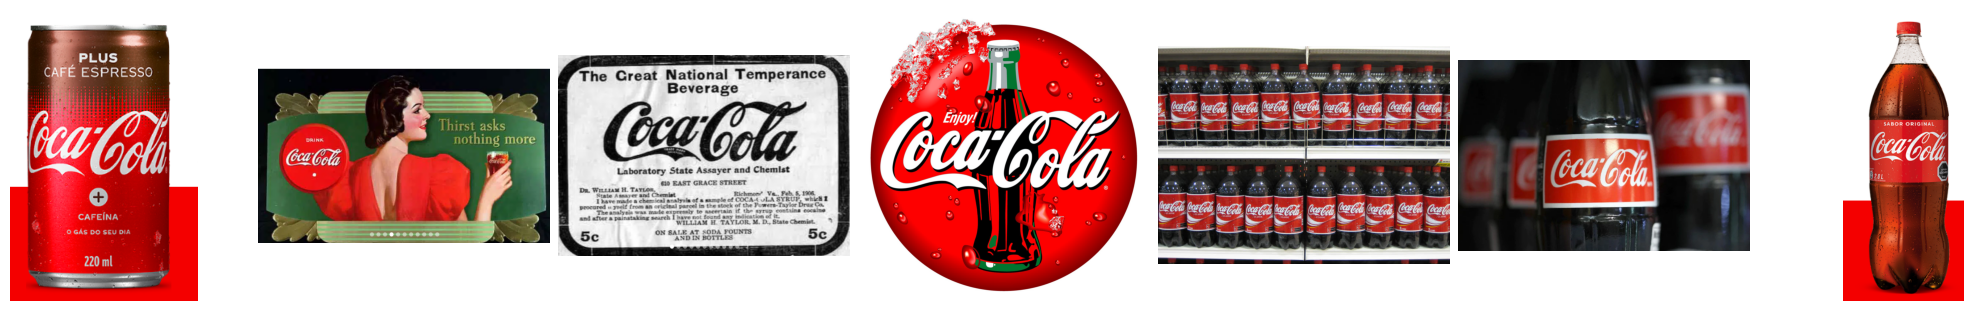

In [87]:
n = len(muestras) 
fig, axs = plt.subplots(1, n, figsize=(3*n, 3), constrained_layout=True)

for i, img in enumerate(muestras):
    axs[i].imshow(img, aspect='equal')
    axs[i].axis('off')
print('******** MUESTRAS ************')
plt.show()

Generación de template de bordes

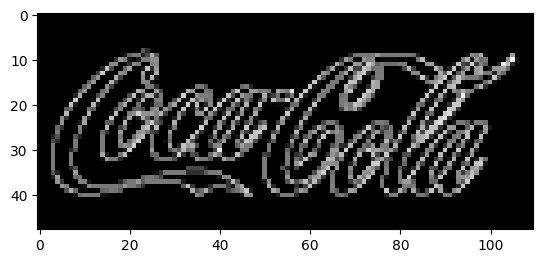

In [5]:
def cokeTemplate( width=110):
    template=cv.imread('./template/pattern.png')
    template_gray = cv.cvtColor(template,cv.COLOR_BGR2GRAY)
    template_gray_bordes = cv.Canny( template_gray, 50 , 200 )
    template_gray_bordes = imutils.resize(template_gray_bordes, width)
    return template_gray_bordes

plt.imshow(cokeTemplate(), cmap='gray'); 

Funcion auxiliar para expandir las imágenes para generar el GIF

In [6]:
def expand_canvas(img, target_h, target_w):
    
    h, w = img.shape[:2]
    color=(0, 0, 0)
    if target_h < h or target_w < w:
        raise ValueError("El tamaño destino debe ser >= al de la imagen.")

    dh, dw = target_h - h, target_w - w
    top, bottom = dh // 2, dh - dh // 2
    left, right = dw // 2, dw - dw // 2

    if img.ndim == 2:  # gris
        val = color if isinstance(color, (int, float)) else (color[0] if isinstance(color, (tuple, list)) else 0)
    else:              # color BGR
        val = color

    return cv.copyMakeBorder(img, top, bottom, left, right, cv.BORDER_CONSTANT, value=val)


La función cokeFind realiza la búsqueda multi-escala utilizando Template Match con el método TM_CCOEFF. 

Parametros*

`muetra_rgb`: La imagen original en RGB
`salida`: path y nombre del arcvhio GIF cone l proceso de búsqueda animado 
`method`: Método de cálculo utilizado por **matchTemplate** para realizar la comarparación
`threshold`: Umbral para evitar falsos positivos

*Retorno*

En caso que el mejor resultado encontrado supere el umbral `threshold`, la función muestra la imagen con un recuadro verde en la posición encontrada, genera un archivo GIF en `salida` con la animación del proceso de comparación. 
En otro caso muestra un mensaje de error



In [88]:

def cokeFind(muestra_rgb, salida, method='cv.TM_CCOEFF', threshold=0.5, fps=4):

	template=cokeTemplate()

	#Dimensiones del template (ancho=w, alto=h)
	tH, tW = template.shape[:2]
	sH,sW = muestra_rgb.shape[:2]
	
	meth = eval(method)
	found = None
	img_gray=cv.cvtColor(muestra_rgb,cv.COLOR_BGR2GRAY)
	img_rgb=muestra_rgb.copy()
	
	frames=[]
	i=0
	# Escalas: de 1.0 a s_end tal que la siguiente iteración ya quede < tW (provoca el break final)
	W0 = img_gray.shape[1]
	s_end = max(1e-3, (tW - 1) / float(W0))  # asegura última iteración < tW
	scales = np.geomspace(1.0, s_end, 25)  # decreciente
	for scale in scales:
				
		resized = imutils.resize(img_gray, width=max(1, int(img_gray.shape[1] * scale)))
		r = img_gray.shape[1] / float(resized.shape[1])

		# Si la imagen reescalada es más pequeña que el template, cortar
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# Bordes para robustecer la correlación 
		edged = cv.Canny(resized, 50, 200)
		
		# matchTemplate sobre imagen reescalada
		
		result = cv.matchTemplate(edged, template, meth)
		minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(result)
		
		if meth in (cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED):
			score, loc = -minVal, minLoc  
		else:
			score, loc = maxVal, maxLoc
		#score, loc = maxVal, maxLoc
		startX, startY = int(loc[0]), int(loc[1])
		endX, endY = startX + tW, startY + tH
		
		edged_rgb=cv.cvtColor(edged,cv.COLOR_GRAY2RGB)
		cv.rectangle(edged_rgb, (startX, startY), (endX, endY), (255, 0, 0), 2)
		frames.append(expand_canvas(edged_rgb,sH,sW))

		# Actualizar mejor coincidencia
		if (found is None) or (score > found[0]):
			found = (score, maxLoc, r, i)
			
		i=i+1
		

	if found is  None or (found[0] < threshold):
		print('No se encontró coincidencia significativa.')
		return
	
	_, maxLoc, r,i = found
	startX, startY = int(maxLoc[0] * r), int(maxLoc[1] * r)
	endX, endY   = int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r)
	cv.rectangle(img_rgb, (startX, startY), (endX, endY), (0, 255, 0), 2)
	#plt.figure(figsize=(6,6))
	plt.imshow(img_rgb)
	plt.title('Resultado de template matching')
	plt.axis('off')
	plt.show()
		
	mask = np.all(frames[i] == [255, 0, 0], axis=-1)
	frames[i][mask] = [0, 255, 0]

	#Crear gif del proceso

	imageio.mimsave(salida+'.gif', frames, fps=fps, loop=0) 
	
		



### Muestra 1

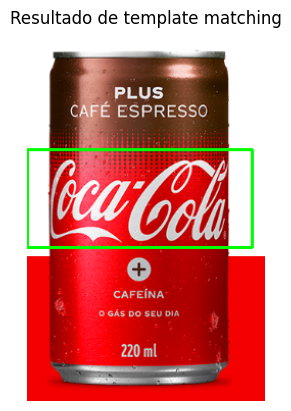

In [89]:
cokeFind(muestras[0], './proceso/'+files[0], 'cv.TM_CCOEFF')


<img src="./proceso/coca_logo_2.png.gif" >

### Muestra 2

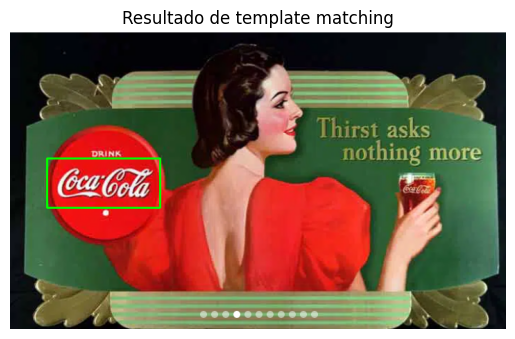

In [90]:
cokeFind(muestras[1], './proceso/'+files[1], 'cv.TM_CCOEFF')


<img src="./proceso/coca_retro_2.png.gif" >

### Muestra 3

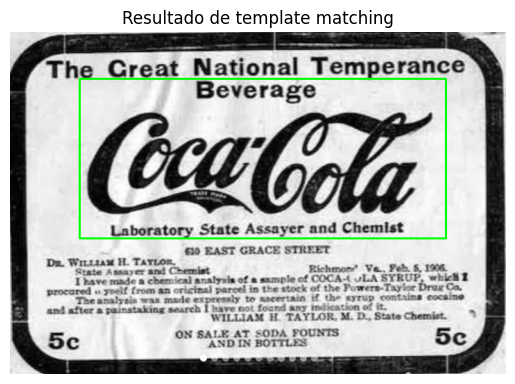

In [91]:
cokeFind(muestras[2], './proceso/'+files[2], 'cv.TM_CCOEFF')


<img src="./proceso/coca_retro_1.png.gif" >

### Muestra 4

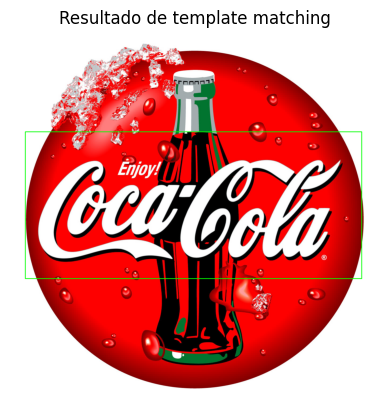

In [92]:
cokeFind(muestras[3], './proceso/'+files[3], 'cv.TM_CCOEFF')


<img src="./proceso/COCA-COLA-LOGO.jpg.gif" >

### Muestra 5

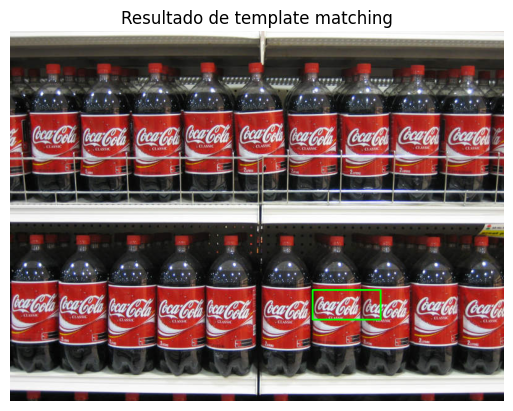

In [93]:
cokeFind(muestras[4], './proceso/'+files[4], 'cv.TM_CCOEFF')


<img src="./proceso/coca_multi.png.gif" >

### Muestra 6

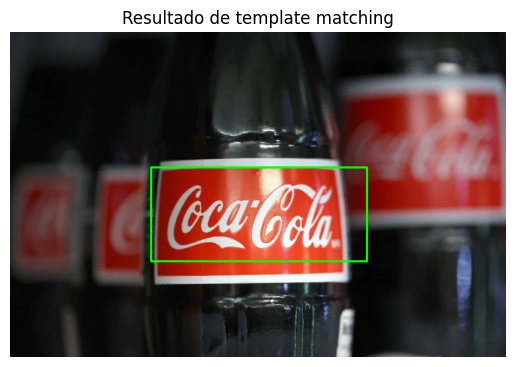

In [84]:
cokeFind(muestras[5], './proceso/'+files[5], 'cv.TM_CCOEFF')


<img src="./proceso/logo_1.png.gif" >

### Muestra 7

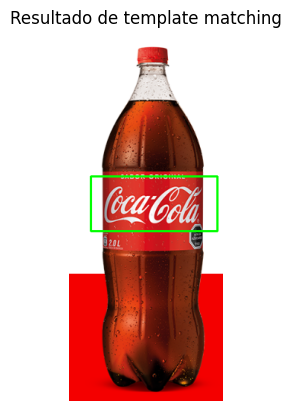

In [85]:
cokeFind(muestras[6], './proceso/'+files[6], 'cv.TM_CCOEFF')


<img src="./proceso/coca_logo_1.png.gif" >